In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil

In [3]:
# Infos + visu rapide X_train
X_train = pd.read_csv('../data/csv_files/X_train_update.csv', index_col = 0)
X_train.head()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [4]:
# Infos + visu rapide y_train
y_train = pd.read_csv('../data/csv_files/Y_train_CVw08PX.csv', index_col = 0)
y_train.head()
y_train.info()
prdtypecodes = set(y_train['prdtypecode'].tolist())
print(len(prdtypecodes))

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB
27


In [5]:
# Analyse taille des images
import os

# liste des path images
train_images_path = '../data/raw/images/image_train'
test_images_path = '../data/raw/images/image_test'
images_list = os.listdir(train_images_path) + os.listdir(test_images_path)
print(f"Nombre total d'images: {len(images_list)}")

# Recuperation size des images
img_size_list = []
img_name_list = []

# recuperation size img train
with os.scandir(train_images_path) as img_path:
    for elem in img_path:
        info = elem.stat()
        img_size_list.append(info.st_size)
        img_name_list.append(elem.name)

# recuperation size img test
with os.scandir(test_images_path) as img_path:
    for elem in img_path:
        info = elem.stat()
        img_size_list.append(info.st_size)
        img_name_list.append(elem.name)

# Dataframe nom / size img
img_size_df = pd.DataFrame(img_size_list, columns = ['image size in bits'])
img_name_df = pd.DataFrame(img_name_list,columns = ['image name'])
img_df = pd.concat([img_size_df, img_name_df], axis = 1)
img_df.head()
img_size_df.describe()

Nombre total d'images: 98728


,image size in bits
count,98728.000000
mean,26578.017705
std,13836.704454
min,2061.000000
25%,15719.000000
50%,24516.000000
75%,35589.250000
max,115744.000000


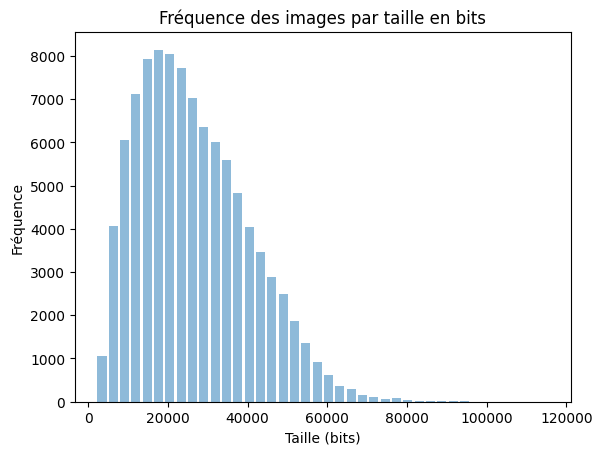

In [6]:
# Analyse distribution size / fréquence des img
import matplotlib.pyplot as plt

img_size_df.plot.hist(y = ['image size in bits'], bins = 40, rwidth = 0.8 , alpha = 0.5, legend = False)
plt.xlabel('Taille (bits)')
plt.ylabel('Fréquence')
plt.title('Fréquence des images par taille en bits')
plt.show()

In [7]:
# Ajout d'une colonne qui contient le nom complet de l'image
X_train['image name'] = 'image_' + X_train['imageid'].map(str) + '_product_' + X_train['productid'].map(str) + '.jpg'
X_train.head()

,designation,description,productid,imageid,image name
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg


In [8]:
# Ajout d'une colonne qui contient la catégorie finale
X_train = X_train.merge(img_df, 'left', 'image name')
X_train['y_train'] = y_train
X_train.head()

,designation,description,productid,imageid,image name,image size in bits,y_train
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg,14010,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg,14854,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg,6898,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg,14404,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg,20435,2705


In [9]:
# Ajout d'une colonne qui contient le descriptif textuel de la catégorie

# Renommage de la colonne "y_train" en "prdtypecode" de X_train
X_train.rename(columns={"y_train": "prdtypecode"}, inplace=True)
#X_train.head()

# import du fichier contenant les désignations textuelles / catégorie niv 1
prdtypecode_to_text = pd.read_csv('../data/csv_files/prdtypecode-classification.csv', sep = ';')
#prdtypecode_to_text.head()

# Fusion des dataframe
X_train = pd.merge(X_train, prdtypecode_to_text[['prdtypecode', 'désignation textuelle', 'catégorie niv 1']], on = 'prdtypecode', how = 'left')
display(X_train.head())

,designation,description,productid,imageid,image name,image size in bits,prdtypecode,désignation textuelle,catégorie niv 1
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg,14010,10,Livres anciens / occasion,Littérature
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg,14854,2280,"journaux, revues, magazines anciens",Littérature
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg,6898,50,Accessoires & produits dérivés gaming,Jeux Vidéos
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg,14404,1280,Jeux & jouets pour enfants,Jeux de société & Jouets
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg,20435,2705,Livres neufs,Littérature


In [10]:
# Export du dataframe "X_train" au format csv
X_train.to_csv('img-data.csv', index = False)

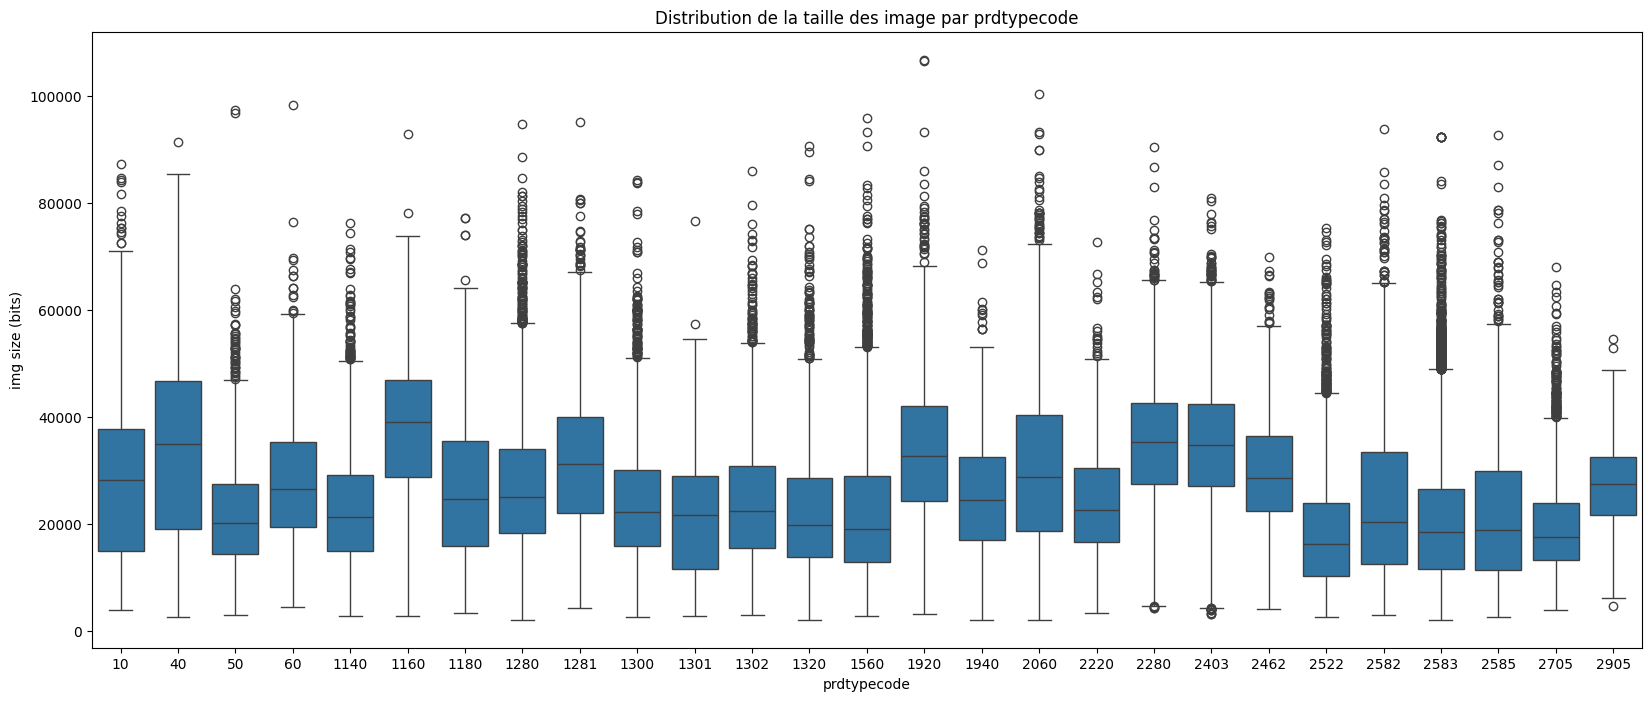

In [10]:
# Vérification taille img / type de produit
plt.figure(figsize = (20, 8))
sns.boxplot(x = 'prdtypecode', y = 'image size in bits', data = X_train)
plt.xlabel('prdtypecode')
plt.ylabel('img size (bits)')
plt.title("Distribution de la taille des image par prdtypecode")
plt.show()

In [12]:
# test ANOVA influence prdtypecode sur size img
# H0 : pas d'influence, moyennes egales
# H1 : influence
import statsmodels.api

X_train = X_train.rename(columns = {'image size in bits': 'image_size_bits'})
df = pd.concat([X_train , y_train], axis = 1)
result = statsmodels.formula.api.ols('image_size_bits ~ prdtypecode', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table

,df,sum_sq,mean_sq,F,PR(>F)
prdtypecode,2.0,1.291795e+11,6.458973e+10,339.604396,1.254379e-147
Residual,84913.0,1.614969e+13,1.901911e+08,NaN,NaN


In [13]:
# Nombre d'images par catégories
count_by_prdtypecode = X_train['prdtypecode'].value_counts()
print("Nombre d'images par catégories:\n", count_by_prdtypecode)

total_prd = X_train['prdtypecode'].value_counts().sum()
print("Nombre total d'images: ", total_prd)

Nombre d'images par catégories:
 prdtypecode
2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: count, dtype: int64
Nombre total d'images:  84916


In [ ]:
# Créer une copie des image_train classées par prdtypecode dans un nouveau repo

source_dir = r'../data/raw/images/image_train'
dest_dir = r'../data/processed/img_classified_by_prdtypecode'

# Création du repo dest
os.makedirs(dest_dir, exist_ok = True)

# Créer un sous-repo pour chaque catégorie
for prdtypecode in df['y_train'].unique():
    category_dir = os.path.join(dest_dir, str(prdtypecode))
    os.makedirs(category_dir, exist_ok = True)

# Copie des img dans chaque sous-repo
for index, row in df.iterrows():
    image_name = row['image name']
    prdtypecode = row['y_train']
    src_path = os.path.join(source_dir, image_name)
    dest_path = os.path.join(dest_dir, str(prdtypecode), image_name)
    shutil.copy2(src_path, dest_path)